Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# Imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import category_encoders as ce

### Plot a confusion matrix for your Tanzania Waterpumps model.

In [0]:

# Imports
import numpy as np
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(train, train_size=0.95, test_size=0.05, 
                              stratify=train['status_group'], random_state=42)

def wrangle(X):
  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Replace small values near zero with zeros
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Drop duplicate columns
  duplicates = ['quantity_group', 'payment_type', 'extraction_type_group', 'source_type', 'source_class']
  X = X.drop(columns=duplicates)

  # Drop recorded_by (never varies) and id (always varies, it is random)
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract components from date_recorded, drop original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  # Engineer feature: how many years from construction date
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  # Replace zeros with nulls and we will impute missing values later
  # Also create a missing indicator column since it could be a  predictive signal
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 
                     'gps_height', 'population', 'num_private', 'amount_tsh']
  
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # Return wrangles dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)


# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [5]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8127946127946128


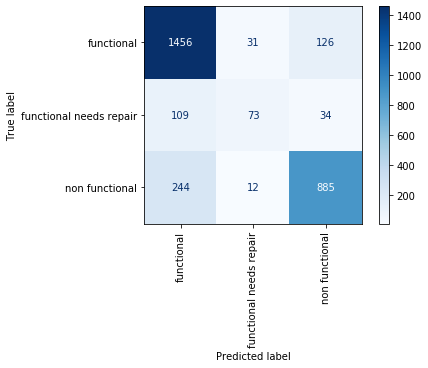

In [6]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline,
                      X_val, y_val,
                      values_format='.0f',
                      xticks_rotation='vertical',
                      cmap='Blues');

In [0]:
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv ('submission_6.csv', index=False)

In [13]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
from google.colab import files
files.download('submission_6.csv')

In [10]:
X_train

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years,years_MISSING
3533,NaN,Government Of Tanzania,1349.0,DWE,35.844477,-4.279121,Kwa Vicent,NaN,Internal,Chalo B,Manyara,21,1,Simanjiro,Loibor Siret,120.0,True,Water Board,Gallapo water supply,True,2010.0,gravity,gravity,vwc,user-group,never pay,soft,good,enough,river,communal standpipe,communal standpipe,2013,2,19,3,False
47070,NaN,Government Of Tanzania,1108.0,RWE,37.578521,-7.056782,Kwa Mzee Msawanga,NaN,Wami / Ruvu,Lolo,Morogoro,5,6,Mvomero,Langali,1.0,True,VWC,Mzinga r,True,NaN,gravity,gravity,vwc,user-group,never pay,soft,good,enough,river,communal standpipe,communal standpipe,2011,3,6,2011,False
18402,NaN,Kkkt,NaN,KKKT,32.984076,-9.068752,Osca Muhanje,NaN,Lake Rukwa,Itende,Mbeya,12,6,Mbozi,Mlowo,NaN,True,VWC,NaN,False,NaN,other,other,vwc,user-group,pay when scheme fails,soft,good,enough,shallow well,other,other,2011,4,16,2011,False
17164,NaN,Amref,29.0,AMREF,39.258859,-7.189203,Kigomba,NaN,Wami / Ruvu,Mwanzega,Pwani,6,4,Mkuranga,Mbezi,400.0,True,VWC,NaN,False,2000.0,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,other,other,2011,3,10,11,False
35729,6000.0,Danida,1410.0,DANID,35.493386,-7.703292,none,NaN,Rufiji,Kilimahewa,Iringa,11,1,Iringa Rural,Nzihi,1.0,True,VWC,Nzihi,True,1994.0,gravity,gravity,vwc,user-group,pay annually,soft,good,dry,spring,communal standpipe,communal standpipe,2011,3,6,17,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,NaN,Government Of Tanzania,NaN,DWE,NaN,NaN,Ofisini,NaN,Lake Victoria,Mimbili Center,Mwanza,19,6,Geita,Nyugwa,NaN,True,VWC,Borehole,True,NaN,afridev,handpump,vwc,user-group,never pay,soft,good,insufficient,machine dbh,hand pump,hand pump,2011,8,10,2011,False
44070,NaN,Dwsp,NaN,DWE,NaN,NaN,Upendo,NaN,Lake Victoria,Mwaumisisi,Shinyanga,17,1,Bariadi,Lugulu,NaN,True,WUG,NaN,False,NaN,nira/tanira,handpump,wug,user-group,never pay,soft,good,insufficient,shallow well,hand pump,hand pump,2013,1,20,2013,False
9112,NaN,World Vision,NaN,Consultant Engineer,32.904407,-4.212569,Kwa Kurwa Mgote,NaN,Lake Tanganyika,Mbale,Tabora,14,1,Nzega,Bukene,NaN,False,VWC,NaN,False,NaN,nira/tanira,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,hand pump,hand pump,2012,10,21,2012,False
8192,30.0,Finida German Tanzania Govt,426.0,Finwater,39.348550,-10.642069,Tangini,NaN,Ruvuma / Southern Coast,Tangini,Mtwara,90,33,Newala,Kitangari,320.0,True,VWC,Mitema,False,1988.0,submersible,submersible,vwc,user-group,pay per bucket,soft,good,insufficient,machine dbh,communal standpipe multiple,communal standpipe,2013,2,7,25,False
